In [0]:
import urllib.request
import re, pickle, os
import numpy as np

from PIL import Image
import requests
from io import BytesIO

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Carregar perfis do GitHub Trending

In [0]:
def get_names(url):
  with urllib.request.urlopen(url) as response:
    html = response.read()

    html = str(html)

    names = []
    for m in re.finditer("alt=\"@", html):
        name = html[m.start()+6:m.start()+30] 
        names.append(name.split("\"")[0])

  return names

def get_trending():
  languages= ['c++', 'c%23', 'c', 'r', 'perl', 'java', 'python', 'swift', 'go', 'html', 'javascript', 'php', 'ruby']
  since = ['daily', 'weekly', 'monthly']
  names_dict = {}
  for language in languages:
    print(language)
    names = []
    for period in since:
      names.extend(get_names("https://github.com/trending/{0}?since={1}".format(language, period)))
      names.extend(get_names("https://github.com/trending/developers/{0}?since={1}".format(language, period)))
    
    names_dict[language] = np.unique(names).tolist()
  return names_dict


if os.path.isfile("github_names.pkl"):
  fp = open("github_names.pkl", "rb")
  names_dict = pickle.load(fp)
  fp.close()
else:
  names_dict = get_trending()
  fp = open("github_names.pkl", "wb")
  pickle.dump(names_dict, fp)
  fp.close()

In [0]:
total = 0
for language in names_dict.keys():
  total += len(names_dict[language])

print(total)

3611


## Face API da Microsoft Azure para extração de atributos da face

In [0]:
!pip install azure-cognitiveservices-vision-face

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 92kB 4.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 


In [0]:
os.environ['FACE_SUBSCRIPTION_KEY'] = ""
os.environ['FACE_ENDPOINT'] = ""

In [0]:
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials

# Set the FACE_SUBSCRIPTION_KEY environment variable with your key as the value.
# This key will serve all examples in this document.
KEY = os.environ['FACE_SUBSCRIPTION_KEY']

# Set the FACE_ENDPOINT environment variable with the endpoint from your Face service in Azure.
# This endpoint will be used in all examples in this quickstart.
ENDPOINT = os.environ['FACE_ENDPOINT']

# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [0]:
def get_face(url):
	single_image_name = os.path.basename(url)
	face_attributes = ['age', 'gender', 'smile', 'facialHair', 'glasses', 'emotion', 'hair', 'makeup']
	try:
		detected_faces = face_client.face.detect_with_url(url=url, return_face_attributes=face_attributes)
		if not detected_faces:
			return {'face': False}
			# raise Exception('No face detected from image {}'.format(single_image_name))
	except:
		return {'face': False}
	
	return dict_face(detected_faces, url)	


In [0]:
def dict_face(detected_faces, url):
  att_dict = {'face': True}
  for face in detected_faces: 
    att_dict['url'] = str(url)
    att_dict['age'] = int(face.face_attributes.age)
    att_dict['gender'] = str(face.face_attributes.gender).split('.')[-1]
    att_dict['smile'] = float(face.face_attributes.smile)
    att_dict['facial_hair'] = face.face_attributes.facial_hair.__dict__
    att_dict['glasses'] = str(face.face_attributes.glasses).split('.')[-1]
    att_dict['emotion'] = face.face_attributes.emotion.__dict__
    att_dict['bald'] = float(face.face_attributes.hair.bald)
    att_dict['hair_color'] = [(str(hair.color).split('.')[-1], float(hair.confidence)) for hair in face.face_attributes.hair.hair_color] 
    att_dict['makeup'] = face.face_attributes.makeup.__dict__

  return att_dict

In [0]:
def get_avatar_url(handle):
  return "https://github.com/{0}.png".format(handle)

if not os.path.isfile("face_attributes.pkl"):
  attributes = {}
  for language in names_dict.keys():
    print(language)
    attributes[language] = []
    for k,handle in enumerate(sorted(names_dict[language])):
      face = get_face(get_avatar_url(handle))
      print('\r{0}/{1}-{2}-'.format(k, len(names_dict[language]), face['face']), end='', flush=True)
      attributes[language].append(face)

  fp = open("face_attributes.pkl", "wb")
  pickle.dump(attributes, fp)
  fp.close()
else:
  fp = open("face_attributes.pkl", "rb")
  attributes = pickle.load(fp)
  fp.close()

## Conversão de atributos para DataFrame Pandas

In [0]:
emocoes = {'anger': 'Raiva', 'contempt': 'Desprezo', 'disgust': 'Nojo', 'fear': 'Medo',
           'happiness': 'Felicidade', 'neutral': 'Neutro', 'sadness': 'Tristeza', 'surprise': 'Surpresa'}

columns = ['Linguagem', 'url', 'Rosto', 'Idade', 'Gênero', 'Sorriso',
      'Pêlos Faciais', 'Bigode', 'Barba', 'Costeleta',
      'Óculos', 'Emoção', 'Careca', 'Cor de cabelo', 'Maquiagem']

df = pd.DataFrame(columns=columns)

for language in attributes.keys():

  for dict_ in attributes[language]:

    row = pd.Series( np.asarray([np.nan]*len(columns)), index=columns)
    row.add(language)
    row.add(dict_['face'])

    row['Linguagem'] = (language)
    row['Rosto'] = (dict_['face'])

    if dict_['face'] == True:
      row['url']   = dict_['url']
      row['Idade'] = (dict_['age'])
      row['Gênero'] = (dict_['gender'])
      row['Sorriso'] = (dict_['smile'])
      row['Óculos'] = (dict_['glasses'])
      row['Careca'] = dict_['bald']
      
      bigode, barba, costeleta = dict_['facial_hair']['moustache'], dict_['facial_hair']['beard'], dict_['facial_hair']['sideburns']
      row['Pêlos Faciais'] = (bigode+barba+costeleta)/3.0
      row['Bigode'] = (bigode)
      row['Barba'] = (barba)
      row['Costeleta'] = (costeleta)

      keys, values = list(dict_['emotion'].keys())[1:], list(dict_['emotion'].values())[1:]
      emotion = keys[np.argmax(values)] 
      row['Emoção'] = (emocoes[emotion]) 
 
      if len(dict_['hair_color']) > 0:
        row['Cor de cabelo'] = max(dict_['hair_color'],key=lambda item:item[1])[0]
      else: row['Cor de cabelo'] = np.nan
      
      row['Maquiagem'] = (dict_['makeup']['eye_makeup'] + dict_['makeup']['lip_makeup'])/2.0

    
    df = df.append(row, ignore_index=True)

df.replace('c%23', 'c#', inplace=True)
display(df)

,Linguagem,url,Rosto,Idade,Gênero,Sorriso,Pêlos Faciais,Bigode,Barba,Costeleta,Óculos,Emoção,Careca,Cor de cabelo,Maquiagem
0,c++,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c++,https://github.com/4ian.png,True,35.0,male,1.000,0.533333,0.6,0.6,0.4,no_glasses,Felicidade,0.10,brown,0.5
2,c++,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c++,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c++,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,ruby,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3607,ruby,https://github.com/yyyc514.png,True,40.0,male,0.589,0.533333,0.6,0.6,0.4,no_glasses,Felicidade,0.07,black,0.0
3608,ruby,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3609,ruby,https://github.com/zdennis.png,True,33.0,male,1.000,0.100000,0.1,0.1,0.1,reading_glasses,Felicidade,0.10,brown,0.0


## Análises com Seaborn

In [0]:
df.describe()

,Idade,Sorriso,Pêlos Faciais,Bigode,Barba,Costeleta,Careca,Maquiagem
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000
mean,30.863322,0.632445,0.229662,0.250692,0.249077,0.189216,0.146442,0.241349
std,8.125906,0.435435,0.190389,0.214767,0.214093,0.179163,0.210568,0.339499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.051000,0.100000,0.100000,0.100000,0.100000,0.030000,0.000000
50%,31.000000,0.967500,0.100000,0.100000,0.100000,0.100000,0.070000,0.000000
75%,35.000000,1.000000,0.400000,0.400000,0.400000,0.400000,0.150000,0.500000
max,72.000000,1.000000,0.900000,0.900000,0.900000,0.900000,0.990000,1.000000


In [0]:
languages = list(df['Linguagem'].unique())
colors = sns.husl_palette(len(languages))

color_dict = {}
for k, lang in enumerate(languages):
  color_dict[lang] = colors[k]

def get_colors(languages):
  return [color_dict[l] for l in languages]

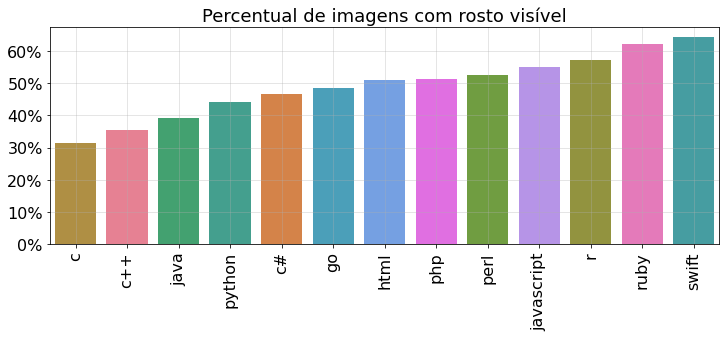

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

result = df.groupby(["Linguagem"])['Rosto'].aggregate(lambda x: sum(x==1)*100.0/x.count()).reset_index().sort_values('Rosto')
palette = get_colors(result['Linguagem'])
sns.barplot(x='Linguagem', y='Rosto', data=df, estimator=lambda x: sum(x==1)*100.0/len(x), 
            ci=None,order=result['Linguagem'], palette=palette)

plt.title('Percentual de imagens com rosto visível', fontsize=18)
plt.xticks(rotation=90, fontsize=16)
ticks = ['{0}%'.format(perc) for perc in np.arange(0, 65, 10)]
plt.yticks(np.arange(0, 65, 10), ticks,fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.grid(True, alpha=0.4)

Text(0, 0.5, '')

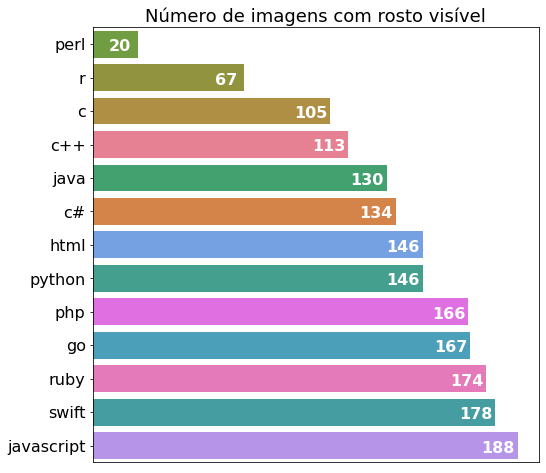

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

result = df.groupby(["Linguagem"])['Rosto'].aggregate(np.sum).reset_index().sort_values('Rosto')
palette = get_colors(result['Linguagem'])
sns.barplot(x='Rosto', y='Linguagem', data=df, estimator=np.sum, orient='h',
            ci=None,order=result['Linguagem'], palette=palette)

num_rostos = result['Rosto'].to_numpy()
for k, language in enumerate(result['Linguagem']):
  plt.text(num_rostos[k]-(len(str(num_rostos[k]))*3.2),k+0.2, str(int(num_rostos[k])), 
           fontsize=16, color='white', fontweight='bold')

plt.title('Número de imagens com rosto visível', fontsize=18)
plt.xticks([])
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('')

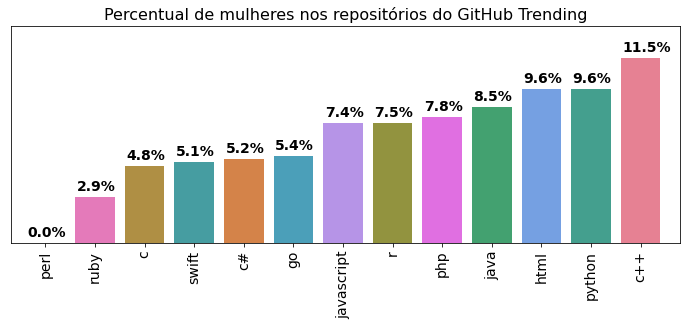

In [0]:
df_gen = df.replace('male', 0)
df_gen = df_gen.replace('female', 1)

plt.figure(figsize=(12, 4))

result = df_gen.groupby(["Linguagem"])['Gênero'].aggregate(lambda x: sum(x==1)*100.0/x.count()).reset_index().sort_values('Gênero')
palette = get_colors(result['Linguagem'])
sns.barplot(data=result, x='Linguagem', y='Gênero', palette=palette)

perc = result['Gênero'].to_numpy()
for k, language in enumerate(result['Linguagem']):
  plt.text(k-0.37, perc[k]+0.4, '{:.1f}%'.format(perc[k]), 
           fontsize=14, color='k', fontweight='semibold')

plt.xticks(rotation=90, fontsize=14)
plt.yticks([])
plt.title('Percentual de mulheres nos repositórios do GitHub Trending', fontsize=16)
plt.ylabel('')
plt.xlabel('')
plt.ylim(0, 13.5)
plt.xlim(-0.7, len(palette)-0.2)
plt.savefig('percentual.png', dpi=150, bbox_inches='tight', format='png')

Text(-0.12835985611084025, 0.5861089893007991, '6.9%')
Text(0.17114641993896926, -0.7814786644189808, '93.1%')


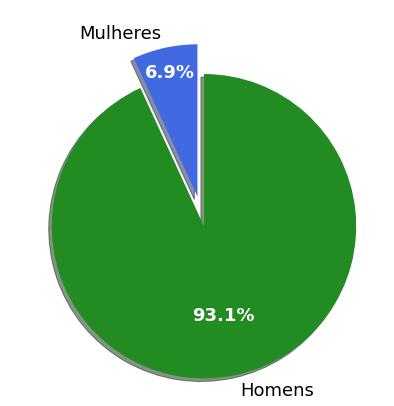

In [0]:
faces = df.groupby('Gênero').sum()

fig1, ax1 = plt.subplots(figsize=(7, 7))
explode = (0, 0.2, )  
patches, texts, autotexts =ax1.pie(faces['Rosto'], explode=explode, labels=['Mulheres', 'Homens'], 
                                   autopct='%1.1f%%', shadow=True, startangle=90, colors=['royalblue', 'forestgreen'])
for text in texts:
    text.set_fontsize(18)

for k,text in enumerate(autotexts):
    text.set_fontsize(18)
    text.set_color('white')
    text.set_fontweight('semibold')
    print(text)

    if k == 0: text.set_position((-0.18, 0.82))
    


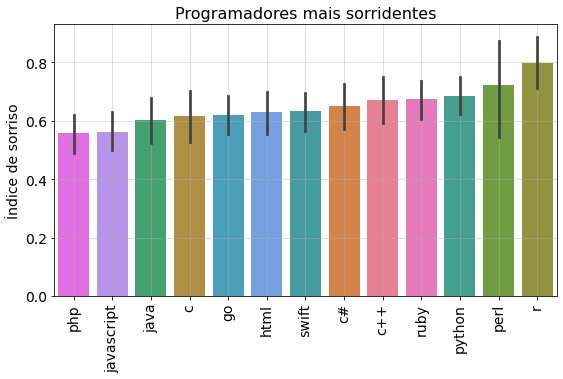

In [0]:
plt.figure(figsize=(9, 5))

result = df_gen.groupby(["Linguagem"])['Sorriso'].aggregate(np.mean).reset_index().sort_values('Sorriso')
palette = get_colors(result['Linguagem'])
sns.barplot(data=df, x='Linguagem', y='Sorriso', order=result['Linguagem'], palette=palette)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.5)
plt.ylabel('Índice de sorriso', fontsize=14)
plt.title('Programadores mais sorridentes', fontsize=16)
plt.xlabel('')
plt.savefig('percentual.png', dpi=150, bbox_inches='tight', format='png')

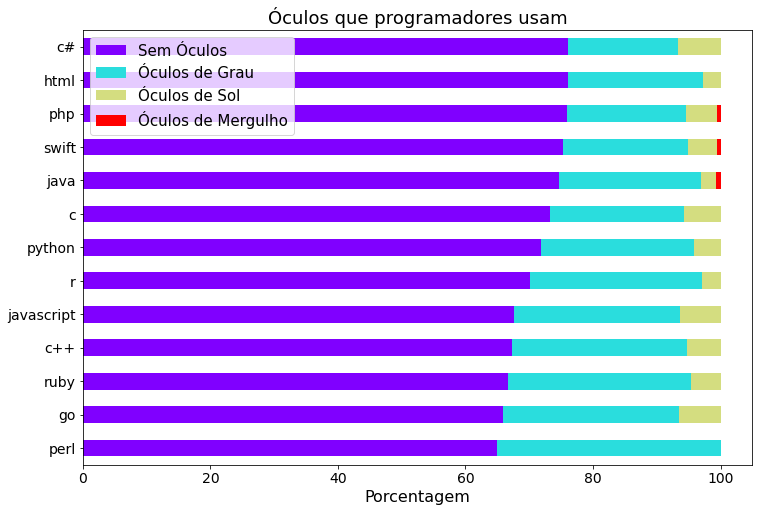

In [0]:
plt.close('all')

df_gen = df.replace('no_glasses', 0)
df_gen = df_gen.replace('reading_glasses', 1)
df_gen = df_gen.replace('sunglasses', 2)
df_gen = df_gen.replace('swimming_goggles', 3)

plt.figure(figsize=(9, 5))

result = df_gen.groupby(["Linguagem"])['Óculos'].aggregate(lambda x: sum(x==0)*100.0/x.count()).reset_index().sort_values('Óculos')
result['Sem Óculos'] = result['Óculos']
result.drop('Óculos', axis=1, inplace=True)
result2 = df_gen.groupby(["Linguagem"])['Óculos'].aggregate(lambda x: sum(x==1)*100.0/x.count()).reset_index().sort_values('Óculos')
result['Óculos de Grau'] = result2['Óculos']
result2 = df_gen.groupby(["Linguagem"])['Óculos'].aggregate(lambda x: sum(x==2)*100.0/x.count()).reset_index().sort_values('Óculos')
result['Óculos de Sol'] = result2['Óculos']
result2 = df_gen.groupby(["Linguagem"])['Óculos'].aggregate(lambda x: sum(x==3)*100.0/x.count()).reset_index().sort_values('Óculos')
result['Óculos de Mergulho'] = result2['Óculos']

result.plot(kind='barh', stacked=True, x='Linguagem', 
            figsize=(12, 8), cmap='rainbow')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=15)
plt.ylabel('')
plt.title('Óculos que programadores usam', fontsize=18)
plt.xlabel('Porcentagem', fontsize=16)
plt.savefig('oculos.png', format='png', dpi=100, bbox_inches='tight')

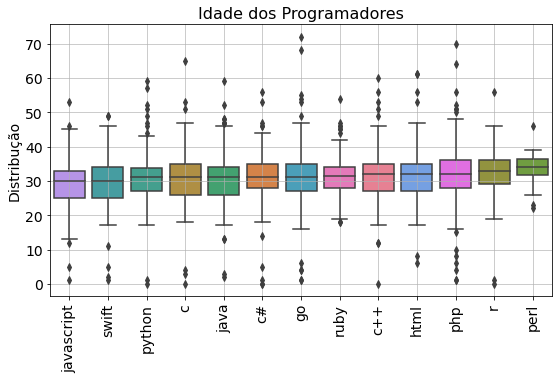

In [0]:
plt.figure(figsize=(9, 5))

result = df.groupby(["Linguagem"])['Idade'].aggregate(np.mean).reset_index().sort_values('Idade')
palette = get_colors(result['Linguagem'])
sns.boxplot(data=df, x='Linguagem', y='Idade', order=result['Linguagem'], palette=palette)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.8)
plt.ylabel('Distribução', fontsize=14)
plt.title('Idade dos Programadores', fontsize=16)
plt.xlabel('')
plt.savefig('percentual.png', dpi=150, bbox_inches='tight', format='png')

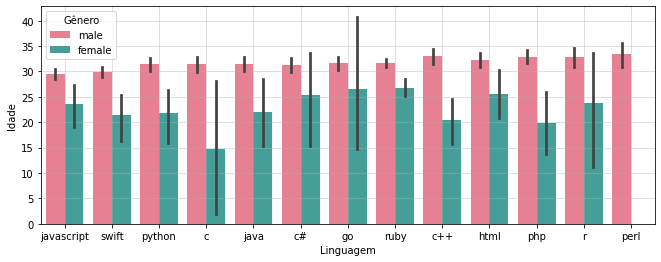

In [0]:
plt.figure(figsize=(11, 4))
result = df.groupby(["Linguagem"])['Idade'].aggregate(np.mean).reset_index().sort_values('Idade')
sns.barplot(data=df, x='Linguagem', y='Idade', hue='Gênero', order=result['Linguagem'], palette='husl')
plt.grid(True, alpha=0.5)
plt.savefig('percentual.png', dpi=150, bbox_inches='tight', format='png')

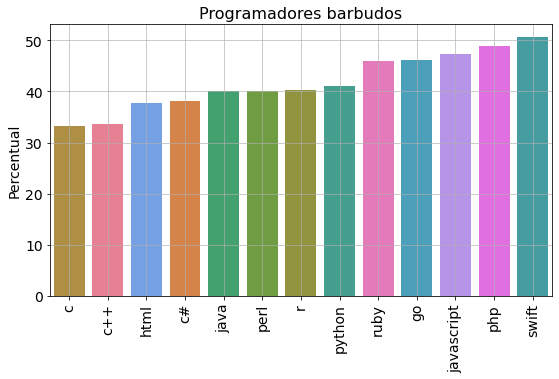

In [0]:
plt.figure(figsize=(9, 5))

result = df.groupby(["Linguagem"])['Pêlos Faciais'].aggregate(lambda x:x.sum()*100.0/x.count()).reset_index().sort_values('Pêlos Faciais')
palette = get_colors(result['Linguagem'])
sns.barplot(data=result, x='Linguagem', y='Pêlos Faciais', palette=palette)

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.8)
plt.ylabel('Percentual', fontsize=14)
plt.title('Programadores barbudos', fontsize=16)
plt.xlabel('')
plt.savefig('percentual.png', dpi=150, bbox_inches='tight', format='png')

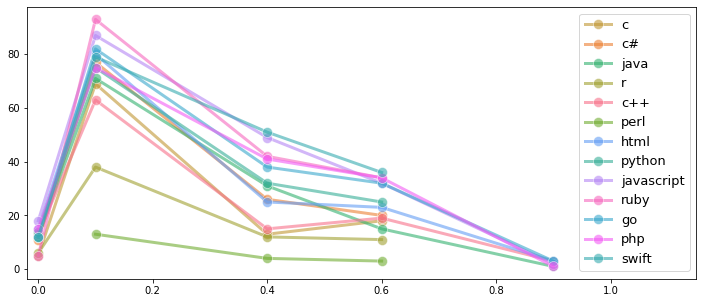

In [0]:
plt.figure(figsize=(12, 5))
result = df.groupby(["Linguagem"])['Bigode'].aggregate(lambda x:x.sum()/x.count()).reset_index().sort_values('Bigode')
palette = get_colors(result['Linguagem'])
for k, language in enumerate(result['Linguagem']):
  val = df[df['Linguagem'] == language]['Bigode'].value_counts()
  sns.lineplot(np.asarray(val.index), val.to_numpy(), marker='o', linewidth=3, 
               alpha=0.6, markersize=10, color=palette[k], label=language)
plt.xlim(-0.02,1.15)
plt.legend(fontsize=13)


(0.1, 0.4)

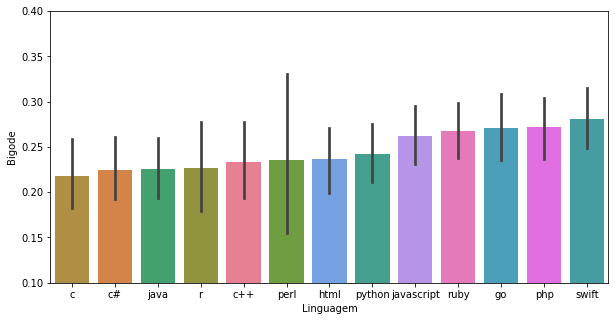

In [0]:
plt.figure(figsize=(10, 5))
result = df.groupby(["Linguagem"])['Bigode'].aggregate(lambda x:x.sum()/x.count()).reset_index().sort_values('Bigode')
palette = get_colors(result['Linguagem'])
sns.barplot(data=df, x='Linguagem', y='Bigode', estimator=np.mean, order=result['Linguagem'], palette=palette)
plt.ylim(0.1, 0.4)

(0.1, 0.32)

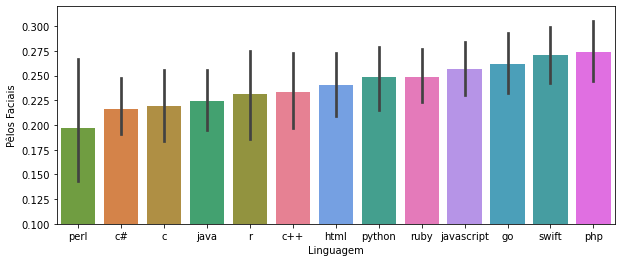

In [0]:
df_fem = df[df['Gênero'] == 'male']
# df_fem.groupby('Linguagem')['Pêlos Faciais'].aggregate(np.mean).reset_index().sort_values('Pêlos Faciais')

result = df_fem.groupby(["Linguagem"])['Pêlos Faciais'].aggregate(lambda x:x.sum()*100.0/x.count()).reset_index().sort_values('Pêlos Faciais')
palette = get_colors(result['Linguagem'])

plt.figure(figsize=(10, 4))
sns.barplot(data=df_fem, x='Linguagem', y='Pêlos Faciais', order=result['Linguagem'], palette=palette)
plt.ylim(0.1, 0.32)

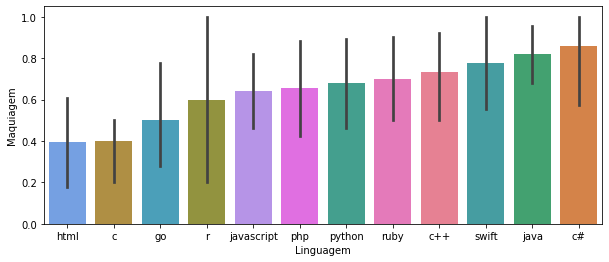

In [0]:
df_fem = df[df['Gênero'] == 'female']

result = df_fem.groupby(["Linguagem"])['Maquiagem'].aggregate(lambda x:x.sum()*100.0/x.count()).reset_index().sort_values('Maquiagem')
palette = get_colors(result['Linguagem'])

plt.figure(figsize=(10, 4))
sns.barplot(data=df_fem, x='Linguagem', y='Maquiagem', order=result['Linguagem'], palette=palette)

# Inferência

In [0]:
df_reg = pd.DataFrame(df)
gender = {'male':0, 'female':1}
glasses = {'no_glasses': 0, 'reading_glasses':1, 'sunglasses': 2, 'swimming_goggles':3}
emotions = {x: k for k, x in enumerate(df_reg['Emoção'].unique()) }
color = {'brown':0, 'black':1, 'blond':2, 'gray':3, 'other':4, 'red':5}
languages = {x: k for k, x in enumerate(df_reg['Linguagem'].unique()) }

df_reg.replace(gender, inplace=True)
df_reg.replace(glasses, inplace=True)
df_reg.replace(emotions, inplace=True)
df_reg.replace(color, inplace=True)
df_reg.replace(languages, inplace=True)
df_reg.fillna(0, inplace=True)

df_reg.head()

,Linguagem,url,Rosto,Idade,Gênero,Sorriso,Pêlos Faciais,Bigode,Barba,Costeleta,Óculos,Emoção,Careca,Cor de cabelo,Maquiagem
0,0,0,False,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,0.0
1,0,https://github.com/4ian.png,True,35.0,0.0,1.0,0.533333,0.6,0.6,0.4,0.0,1,0.1,0,0.5
2,0,0,False,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,0.0
3,0,0,False,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,0.0
4,0,0,False,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,0.0


In [0]:
df_reg = df_reg[df_reg['Rosto'] == True]
# df_reg = df_reg[df_reg['Linguagem']!= 4]
X = df_reg.to_numpy()
Y = X[:,0]
X = X[:, 3:]

Y = Y.astype(float)

print(X[0], Y[0], len(X))

[35.0 0.0 1.0 0.5333333333333333 0.6 0.6 0.4 0.0 1 0.1 0 0.5] 0.0 1735


In [0]:
print(languages)
languagesidx = {v: k for k, v in languages.items()}
print(languagesidx)

{'c++': 0, 'c#': 1, 'c': 2, 'r': 3, 'perl': 4, 'java': 5, 'python': 6, 'swift': 7, 'go': 8, 'html': 9, 'javascript': 10, 'php': 11, 'ruby': 12}
{0: 'c++', 1: 'c#', 2: 'c', 3: 'r', 4: 'perl', 5: 'java', 6: 'python', 7: 'swift', 8: 'go', 9: 'html', 10: 'javascript', 11: 'php', 12: 'ruby'}


In [0]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

gnb = MultinomialNB(class_prior=[0.5]*13)
ypred = gnb.fit(X_train, y_train).predict(X_train)
print(gnb.class_count_)
print(accuracy_score(ypred, y_train))
ypred = gnb.predict(X_test)
print(accuracy_score(ypred, y_test))


probs = gnb.predict_proba(X_test)
best_n = np.argsort(probs, axis=1)[:,-5:]
topkacc = [1 if y_test[k] in best_n[k] else 0 for k in range(len(y_test))]
np.sum(topkacc)/float(len(topkacc))

[101. 119.  94.  61.  19. 113. 136. 162. 143. 133. 172. 151. 157.]
0.11467008327994875
0.09770114942528736


0.47701149425287354

In [0]:
emocoes = {'anger': 'Raiva', 'contempt': 'Desprezo', 'disgust': 'Nojo', 'fear': 'Medo',
           'happiness': 'Felicidade', 'neutral': 'Neutro', 'sadness': 'Tristeza', 'surprise': 'Surpresa'}

def att2feat(att):
  row = {}

  row['Idade'] = att['age']
  row['Gênero'] = gender[att['gender']]
  row['Sorriso'] = att['smile']

  bigode, barba, costeleta = att['facial_hair']['moustache'], att['facial_hair']['beard'], att['facial_hair']['sideburns'] 
  row['Pêlos Faciais'] = (bigode + barba + costeleta)/3.0
  row['Bigode'] = (bigode)
  row['Barba'] = (barba)
  row['Costeleta'] = (costeleta)

  row['Óculos'] = glasses[att['glasses']]
  keys, values = list(att['emotion'].keys())[1:], list(att['emotion'].values())[1:]
  emotion = keys[np.argmax(values)] 
  row['Emoção'] = emotions[emocoes[emotion]] 

  row['Careca'] = att['bald']
  if len(att['hair_color']) > 0:
    row['Cor de cabelo'] = color[max(att['hair_color'],key=lambda item:item[1])[0]]
  else: row['Cor de cabelo'] = 0
  
  row['Maquiagem'] = (att['makeup']['eye_makeup'] + att['makeup']['lip_makeup'])/2.0

  row = pd.Series(row)
  return np.array(row.values)


{'face': True, 'url': 'https://www.cartacapital.com.br/wp-content/uploads/2020/03/Drauzio-Varella-1200x720.jpg', 'age': 67, 'gender': 'male', 'smile': 1.0, 'facial_hair': {'additional_properties': {}, 'moustache': 0.1, 'beard': 0.1, 'sideburns': 0.1}, 'glasses': 'no_glasses', 'emotion': {'additional_properties': {}, 'anger': 0.0, 'contempt': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happiness': 1.0, 'neutral': 0.0, 'sadness': 0.0, 'surprise': 0.0}, 'bald': 0.86, 'hair_color': [], 'makeup': {'additional_properties': {}, 'eye_makeup': False, 'lip_makeup': False}}
[('python', 0.07961250026555677), ('html', 0.08310210870215351), ('c++', 0.09688602604067882), ('c#', 0.10238264502973891), ('r', 0.12656789749422656)]


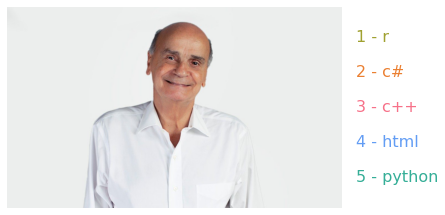

In [0]:
from PIL import Image

url = 'https://www.cartacapital.com.br/wp-content/uploads/2020/03/Drauzio-Varella-1200x720.jpg'

face = get_face(url)
print(face)
feat = att2feat(face)

response = requests.get(url)
img = Image.open(BytesIO(response.content))

probs = gnb.predict_proba( feat[np.newaxis,:] )
best_n = np.argsort(probs, axis=1)[:,-5:]
languages = [(languagesidx[n], probs[0,n]) for n in best_n[0]]
print(languages)

plt.imshow(img)
plt.axis('off')
x = np.array(img).shape[1]+50
for k, lang in enumerate(languages[::-1]):
  plt.text(x, (k+1) * x/10.0, str(k+1)+' - '+lang[0], fontsize=16, color=get_colors([lang[0]])[0])

plt.savefig('drauzio.png', dpi=150, format='png', bbox_inches='tight')
plt.show()

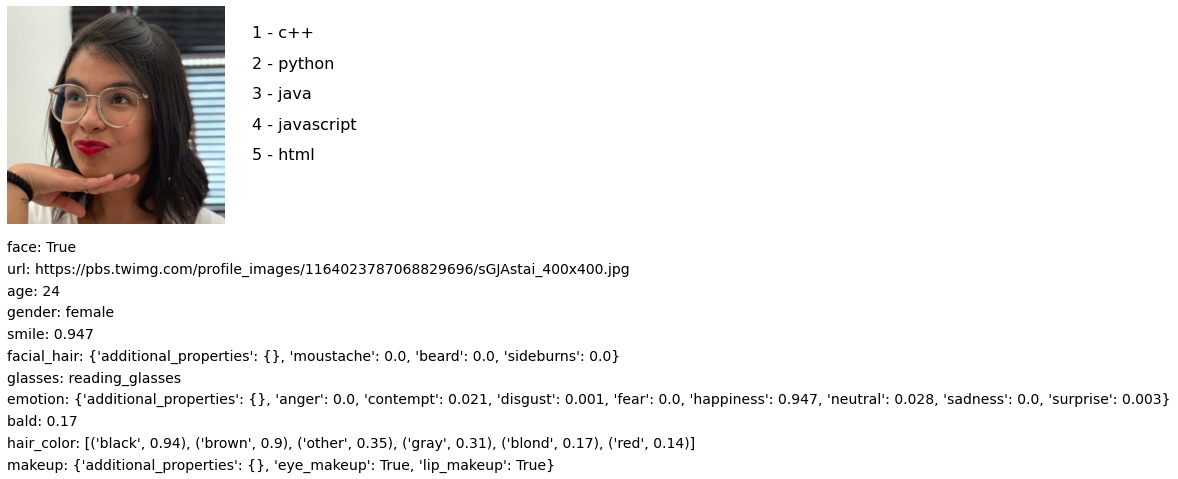

In [0]:
# img, face, topling = run('https://pbs.twimg.com/profile_images/1164023787068829696/sGJAstai_400x400.jpg')
url = 'https://pbs.twimg.com/profile_images/1164023787068829696/sGJAstai_400x400.jpg'
face = get_face(url)
feat = att2feat(face)

response = requests.get(url)
img = Image.open(BytesIO(response.content))

probs = gnb.predict_proba( feat[np.newaxis,:] )
best_n = np.argsort(probs, axis=1)[:,-5:]
languages = [languagesidx[n] for n in best_n[0]]

plt.imshow(img)
plt.axis('off')
x = np.array(img).shape[1]+50
for k, lang in enumerate(languages[::-1]):
  plt.text(x, (k+1) * x/8., str(k+1)+' - '+lang, fontsize=16)

y = np.array(img).shape[0]+50
for k, (key, value) in enumerate(face.items()):
  plt.text(0, y + (k*40) , str(key) + ': ' + str(value), fontsize=14)
